> Testing of binary sentiment classification on a IMDb movie review dataset.

---

# Setup

##### Set Root Dir as CWD

In [1]:
import os

# Navigate to project root (if not already there)
if os.path.split(os.getcwd())[1] != "cs374-project":
    %cd ../

D:\Documents\A_DIGIPEN\PersonalSVN\Fall22SVN\CS374\Project\cs374-project


##### Imports

In [2]:
import numpy as np
import pandas as pd

import spacy

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Local
from src.preprocesser import ReviewPreprocessor
from src.model import ReviewClassifier

# Load

In [3]:
path = "data/imdb/"

In [4]:
%%time
# Load dev set (10% of total data) as train
val = pd.read_csv(path + "IMDB Dataset.csv")

CPU times: total: 281 ms
Wall time: 360 ms


In [29]:
# Remove html tags
val["review"] = val["review"].str.replace(r"<.*?>", "", regex=True)

In [30]:
val

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. The filming tec...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


##### Save Target

In [31]:
# Save sentiment as boolean
y_val = val["sentiment"] == "positive"
y_val

0         True
1         True
2         True
3        False
4         True
         ...  
49995     True
49996    False
49997    False
49998    False
49999    False
Name: sentiment, Length: 50000, dtype: bool

# Preprocess

In [32]:
batch_size = 4000
n_processes = 4

maxlen = 200         # Number of words per review to consider
vocab_size = 20_000  # Size of vocabulary

prep_path = f"experiments/preprocessors/final.pickle"

##### Load from raw data

In [33]:
%%time
# Configure preprocessor based on comparison
prep = ReviewPreprocessor.load_from_pickle(prep_path)

# Preprocess text
X_val_norm = prep.normalize(val["review"], batch_size, n_processes)

# Convert to tensor of padded sequences
X_val = prep.to_tensor(X_val_norm)

CPU times: total: 1min 12s
Wall time: 4min 10s


##### View Before and After Preprocessing

In [34]:
print_idx = 8
print(val["review"].iloc[print_idx])
print("\n - - - - \n")
print(X_val_norm[print_idx], len(X_val_norm[print_idx]))
print("\n - - - - \n")
print(X_val[print_idx])

Encouraged by the positive comments about this film on here I was looking forward to watching this film. Bad mistake. I've seen 950+ films and this is truly one of the worst of them - it's awful in almost every way: editing, pacing, storyline, 'acting,' soundtrack (the film's only song - a lame country tune - is played no less than four times). The film looks cheap and nasty and is boring in the extreme. Rarely have I been so happy to see the end credits of a film. The only thing that prevents me giving this a 1-score is Harvey Keitel - while this is far from his best performance he at least seems to be making a bit of an effort. One for Keitel obsessives only.

 - - - - 

['encouraged', 'by', 'the', 'positive', 'comments', 'about', 'this', 'film', 'on', 'here', 'i', 'was', 'looking', 'forward', 'to', 'watching', 'this', 'film', '.', 'bad', 'mistake', '.', 'i', "'", 've', 'seen', '95', 'e1', '+', 'films', 'and', 'this', 'is', 'truly', 'CARDINAL', 'of', 'the', 'worst', 'of', 'them', '-'

# Model

##### Load Model

In [35]:
# From saved model (doesn't work with attn scores)
#model = keras.models.load_model("experiments/models/final_model")

# From checkpoint
embed_dim = 32  # Attention output size
num_heads = 2   # Number of attention heads
ff_dims = [32]  # Hidden layer sizes in feed forward network inside transformer
reg = 1.0e-2    # L2 Reg based on comparison
dropout = 0.3   # Dropout based on comparison
cp_path = "experiments/model_checkpoints/"
model = ReviewClassifier(maxlen, vocab_size, embed_dim, num_heads, ff_dims, reg, dropout)
model.load_weights(cp_path + f"final.ckpt")

In [36]:
model.predict(X_val[:5])

1/1 [==============================] - 0s 248ms/step


array([[3.3634059e-02, 1.6372284e-02, 2.8583718e-02, 1.4193356e-01,
        7.7947640e-01],
       [4.1847605e-07, 3.0608060e-06, 1.5645857e-03, 1.4461283e-01,
        8.5381913e-01],
       [7.9776754e-04, 1.7223358e-03, 2.5808359e-02, 2.4764423e-01,
        7.2402734e-01],
       [6.7655426e-01, 2.5150737e-01, 6.3111648e-02, 7.0397453e-03,
        1.7869679e-03],
       [2.1432120e-02, 1.7029442e-02, 4.3839652e-02, 1.9746016e-01,
        7.2023863e-01]], dtype=float32)

# Evaluate

In [37]:
# Get probabilities per class
y_pred = model.predict(X_val)

1563/1563 [==============================] - 2s 1ms/step


In [38]:
# Calculate continuous star rating based on probabilities
star_reg = tf.reduce_sum(y_pred * np.array([0, 1, 2, 3, 4]), axis=1)
star_reg

<tf.Tensor: shape=(50000,), dtype=float64, numpy=
array([3.61757274, 3.85226468, 3.69235783, ..., 1.41662982, 2.20706032,
       0.39307531])>

In [39]:
# Determine if sentiment is negative or postiive
y_pred_binary = star_reg >= 2

In [40]:
print("binary accuracy: " + str((y_pred_binary == y_val).numpy().sum() / len(y_val)))
print("(compare to ~0.5)")

binary accuracy: 0.7922
(compare to ~0.5)


##### Visualize Attention

In [22]:
# Get attention scores
_, attns = model(X_val[:100], return_att=True)

# Get attention for each sample
attns = tf.reduce_mean(attns, axis=2)[:, 0, :]
attns

<tf.Tensor: shape=(100, 200), dtype=float32, numpy=
array([[3.5445732e-03, 1.2494006e-02, 1.9155605e-02, ..., 7.6461699e-09,
        2.1221755e-10, 4.8084628e-02],
       [6.4915861e-03, 1.4879075e-01, 2.1933308e-01, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.5523669e-03, 1.7574768e-01, 6.2144117e-04, ..., 2.4621802e-10,
        2.4426347e-08, 2.8748524e-08],
       ...,
       [2.1435758e-01, 8.9798840e-03, 5.2412588e-08, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [2.0146836e-04, 6.1077247e-03, 8.8913605e-02, ..., 2.8045032e-11,
        4.1055009e-03, 3.1361555e-08],
       [2.3471093e-05, 1.7754437e-01, 1.2505965e-01, ..., 2.6696836e-05,
        4.2042211e-03, 3.6824733e-06]], dtype=float32)>

In [23]:
attns[0][:34]

<tf.Tensor: shape=(34,), dtype=float32, numpy=
array([3.5445732e-03, 1.2494006e-02, 1.9155605e-02, 1.0774131e-01,
       1.8801376e-01, 7.6504983e-03, 1.0714605e-01, 4.0157047e-06,
       1.4494486e-03, 1.4054523e-04, 2.0329878e-07, 4.3246388e-02,
       6.2153226e-04, 3.8715727e-03, 4.4076633e-06, 3.7952331e-03,
       7.6869931e-03, 1.7510286e-02, 6.7335197e-05, 1.5638797e-02,
       1.1256127e-06, 2.6232949e-03, 2.2619017e-03, 3.5805228e-05,
       1.0287581e-05, 3.5656402e-07, 9.8734386e-03, 2.9696450e-03,
       1.0313178e-02, 7.9576488e-08, 1.0125336e-06, 1.6604311e-08,
       2.2623732e-09, 9.3440833e-10], dtype=float32)>

<Original Text>
An awful film! It must have been up against some real stinkers to be nominated for the Golden Globe. They've taken the story of the first famous female Renaissance painter and mangled it beyond recognition. My complaint is not that they've taken liberties with the facts; if the story were good, that would perfectly fine. But it's simply bizarre -- by all accounts the true story of this artist would have made for a far better film, so why did they come up with this dishwater-dull script? I suppose there weren't enough naked people in the factual version. It's hurriedly capped off in the end with a summary of the artist's life -- we could have saved ourselves a couple of hours if they'd favored the rest of the film with same brevity.

<Preprocessed>
['an', 'awful', 'film', 'it', 'must', 'have', 'been', 'up', 'against', 'some', 'real', 'to', 'be', 'for', 'fac', 'fac', 'fac', 'they', "'", 've', 'taken', 'the', 'story', 'of', 'the', 'ordinal', 'famous', 'female', 'org', 'pai

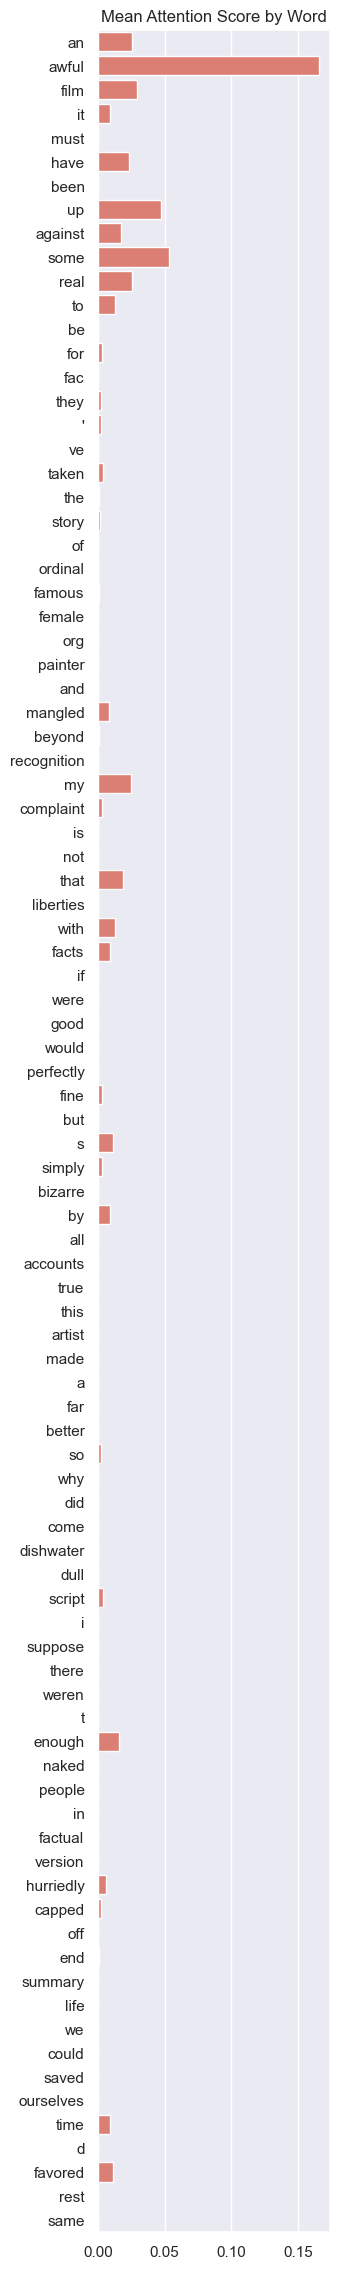

In [49]:
sample_idx = 19

# Get word sequences without oov words
in_seq = X_val_norm[sample_idx][:maxlen]
in_seq = [tok for tok in prep.tokenizer.sequences_to_texts(prep.tokenizer.texts_to_sequences(in_seq)) if tok]
seq_len = len(in_seq)

# Get attention values
attn_vals = attns[sample_idx][:seq_len].numpy()

print("<Original Text>")
print(val["review"].iloc[sample_idx])

print("\n<Preprocessed>")
print(in_seq)

plt.figure(figsize=(3, 0.2 * seq_len), dpi=100)
sns.barplot(y=in_seq, x=attn_vals, ci=None, color="#EC7063")

plt.title("Mean Attention Score by Word")

#plt.gca().set_yticklabels(in_seq)

plt.show()